# Import libraries

In [66]:
import matplotlib.pyplot as plt
import warnings
import time,sys
import copy

import pandas as pd
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import pathlib
import shutil
from pathlib import Path
from collections import Counter
!pip install torchsummary
from torchsummary import summary

!pip install torchviz
from torchviz import make_dot, make_dot_from_trace

warnings.filterwarnings('ignore')
torch.manual_seed(0)

# Mounting Drive

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Creation

In [68]:
!gdown --id 10TbLFo2cgcmlNjgQMZeiI_D68StH5gfW

Downloading...
From: https://drive.google.com/uc?id=10TbLFo2cgcmlNjgQMZeiI_D68StH5gfW
To: /content/Dataset C.zip
162MB [00:01, 135MB/s]


In [69]:
!unzip '/content/Dataset C.zip'

Archive:  /content/Dataset C.zip
replace training-c/c00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load dataset from drive

In [70]:
training_csv = "/content/training-c.csv"
read_df = pd.read_csv(training_csv)

read_df.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [71]:
number_of_digit_class = 10
for i in range(0,number_of_digit_class):
  select_digit = read_df[read_df['digit'] == i]
  print(i , select_digit.shape )

0 (2438, 7)
1 (2403, 7)
2 (2437, 7)
3 (2438, 7)
4 (2446, 7)
5 (2444, 7)
6 (2442, 7)
7 (2445, 7)
8 (2400, 7)
9 (2405, 7)


## Store into digit based folders

In [72]:
number_of_digit_class = read_df['digit'].nunique()

DATASET_ROOT_DIR = './PROCESSED_DATASET_170104019/' 
path = Path(DATASET_ROOT_DIR)
path.mkdir(parents=True, exist_ok=True)
DATASET_ROOT_DIR = os.path.abspath(path)

for i in range(0,number_of_digit_class):
  select_digit = read_df[read_df['digit'] == i]
  for index,val in select_digit.iterrows():
    file_relative_path_from= f"./{val['database name']}/{val['filename']}"
    file_relative_dir_to = f"{DATASET_ROOT_DIR}/{val['digit']}"
    Path(file_relative_dir_to).mkdir(parents=True, exist_ok=True)
    shutil.copy(file_relative_path_from, file_relative_dir_to)
    print(file_relative_path_from , file_relative_dir_to , "OK")

Streaming output truncated to the last 5000 lines.
./training-c/c22339.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22368.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22403.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22404.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22415.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22423.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22435.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22456.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22462.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22477.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22488.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22497.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22513.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22517.png /content/PROCESSED_DATASET_170104019/7 OK
./training-c/c22524.png /

## Variable Declaration

In [73]:
base_dir = '/content/PROCESSED_DATASET_170104019' 
BATCH_SIZE = 20

# 28(model-1), 128(model-2), 224(model-3),
IMAGE_SIZE = 28
LEARNING_RATE = 0.01
TEST_SIZE = 0.2
OUTPUT_DIM=10

## Load Dataset

In [74]:
# transform = transforms.Compose([
#                                 transforms.Grayscale(),                               
#                                 transforms.Resize(IMAGE_SIZE),  ## image resize
#                                 transforms.CenterCrop(IMAGE_SIZE), ## image center crop
#                                 transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
#                                ])

# #load training dataset 
# dataset = torchvision.datasets.ImageFolder(base_dir, transform=transform)
# n = len(dataset) 
# n_test = int(TEST_SIZE * n) # 10% validation
# trainDataset, validDataSet = torch.utils.data.random_split(dataset,[n - n_test,n_test]) #random split dataset
# trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,) 
# validationloader = torch.utils.data.DataLoader(validDataSet, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,) 
# print("Length of the trainloader:", len(trainloader ) * BATCH_SIZE)
# print("Length of the validationloader:", len(validationloader ) * BATCH_SIZE)

In [75]:

trainDataset = torchvision.datasets.FashionMNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),  # Normalize the image to [0-1] from [0-255]
                            download=True)

validDataSet = torchvision.datasets.FashionMNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
MAKING DATASET ITERABLE
'''

trainloader = torch.utils.data.DataLoader(dataset=trainDataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

validationloader = torch.utils.data.DataLoader(dataset=validDataSet, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)  

print("Length of the trainloader:", len(trainloader ) * BATCH_SIZE)
print("Length of the validationloader:", len(validationloader ) * BATCH_SIZE)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Length of the trainloader: 60000
Length of the validationloader: 10000


## Explore Dataset

In [76]:
dataset.class_to_idx # class map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [77]:
print(dict(Counter(dataset.targets))) # count number of data in a class

{0: 2438, 1: 2403, 2: 2437, 3: 2438, 4: 2446, 5: 2444, 6: 2442, 7: 2445, 8: 2400, 9: 2405}


In [78]:
train_classes = [label for _, label in trainDataset]
print(dict(Counter(train_classes)))

{9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000}


In [79]:
val_classes = [label for _, label in validDataSet]
print(dict(Counter(val_classes)))

{9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000}


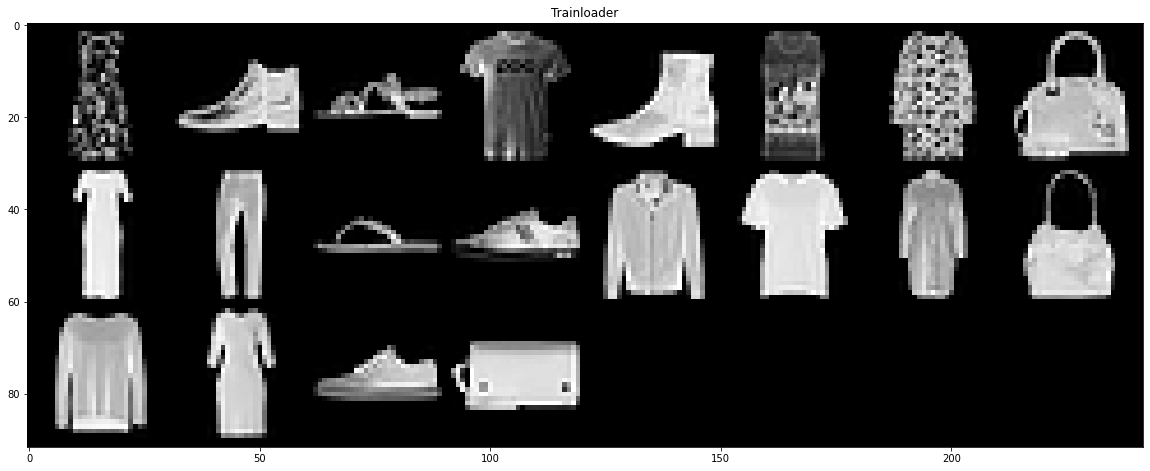

tensor([3, 9, 5, 0, 9, 0, 3, 8, 3, 1, 5, 7, 4, 0, 3, 8, 2, 3, 7, 8])


In [80]:
for image,label in trainloader:
  plt.figure(figsize=(20,20))
  grid_imge_gen = torchvision.utils.make_grid(image)
  plt.imshow(grid_imge_gen.permute(1, 2, 0).cpu())
  plt.title("Trainloader")
  plt.show()
  print(label)
  break

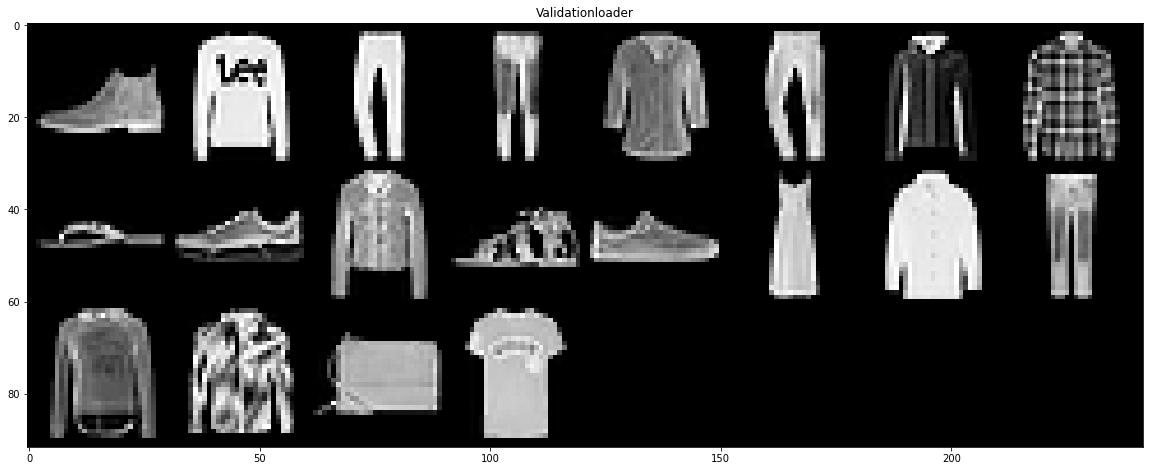

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0])


In [81]:
for image,label in validationloader:
  plt.figure(figsize=(20,20))
  grid_imge_gen = torchvision.utils.make_grid(image)
  plt.imshow(grid_imge_gen.permute(1, 2, 0).cpu())
  plt.title("Validationloader")
  plt.show()
  print(label)
  break

# Model

In [82]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [83]:
'''
Model creation 
'''

class LIN_MODEL(torch.nn.Module): 
    def __init__(self,outDim):
        super(LIN_MODEL, self).__init__()

        self.fc_1 = torch.nn.Linear(784, 90)
        self.fc_2 = torch.nn.Linear(90, 50)
        self.fc_3 = torch.nn.Linear(50, 30)
        self.fc_4 = torch.nn.Linear(30, 18)
        self.fc_5 = torch.nn.Linear(18, 12)
        self.fc_6 = torch.nn.Linear(12, outDim)

        self.linear = torch.nn.Linear(784, outDim)
 
    def forward(self, x):

        x = x.view(-1, 28 * 28) 
        x = torch.nn.functional.relu(self.fc_1(x))
        x = torch.nn.functional.softmax(self.fc_2(x),dim=1)
        x = torch.nn.functional.relu(self.fc_3(x))
        x = torch.nn.functional.softmax(self.fc_4(x),dim=1)
        x = torch.nn.functional.relu(self.fc_5(x))
        x = self.fc_6(x)
        # x = torch.nn.functional.softmax(self.linear(x),dim=1)
        return x
        

model_1 = LIN_MODEL(OUTPUT_DIM).to(device)

summary( model_1, input_size=(1, 28, 28))
# select CPU or GPU as a device
print(model_1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 90]          70,650
            Linear-2                   [-1, 50]           4,550
            Linear-3                   [-1, 30]           1,530
            Linear-4                   [-1, 18]             558
            Linear-5                   [-1, 12]             228
            Linear-6                   [-1, 10]             130
Total params: 77,646
Trainable params: 77,646
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.30
----------------------------------------------------------------
LIN_MODEL(
  (fc_1): Linear(in_features=784, out_features=90, bias=True)
  (fc_2): Linear(in_features=90, out_features=50, bias=True)
  (fc_3): Linear(in_features=50, out_f

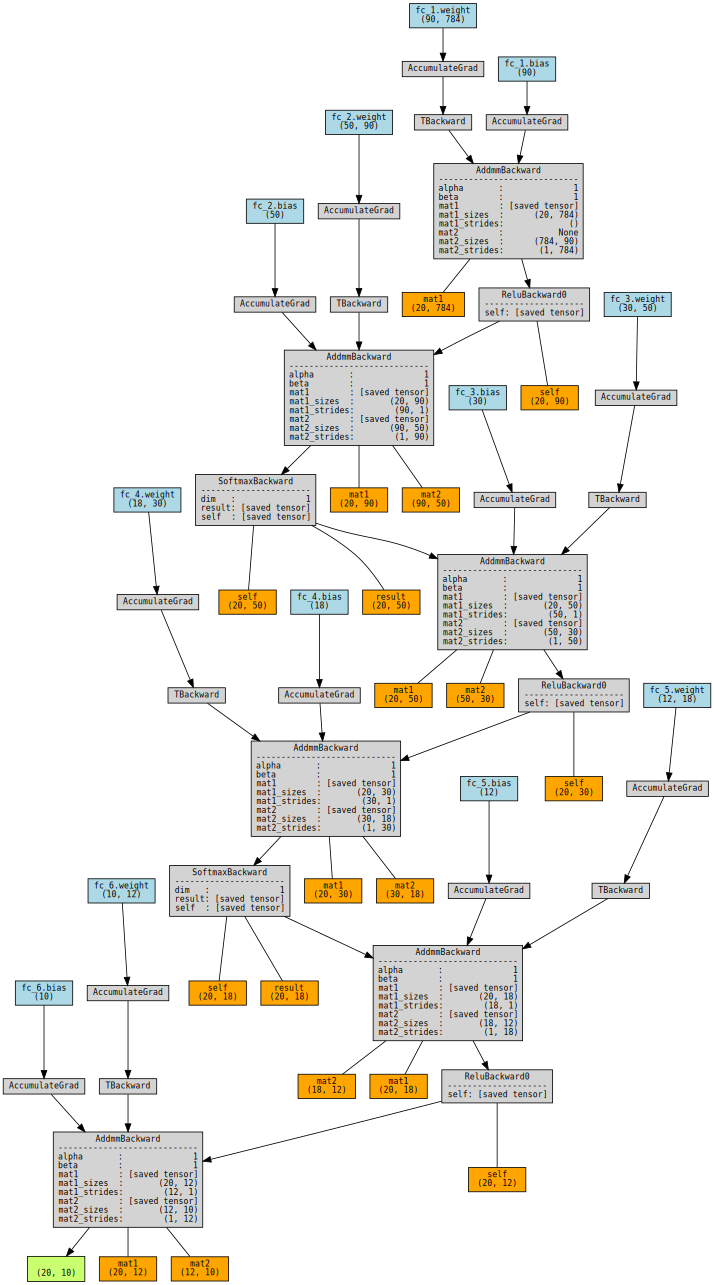

In [84]:
x = torch.randn(BATCH_SIZE,1,28,28).to(device)
make_dot(model_1(x), params=dict(model_1.named_parameters()), show_attrs=True, show_saved=True)

In [85]:
make_dot(model_1(x), params=dict(model_1.named_parameters()), show_attrs=True, show_saved=True).render("Model-1", format="png")

'Model-1.png'

In [86]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=LEARNING_RATE, )

# Trainning

## Save Model

In [87]:
def save_model(
               MODEL_USED,
               SAVEPATH,
               epoch, 
               batch_size, 
               model,
               optimizer,
               image_size,
               tranning_loss=[],
               tranning_acc=[],
               validation_loss=[],
               validation_acc=[],
               learning_rate=0.001,
               meta_data=None):
  SAVEPATH += f"{MODEL_USED}-checkpoint-epoch-{epoch}.pt"
  save_obj = {
       'MODEL_USED':MODEL_USED,
       'batch_size':batch_size,
       'epoch': epoch,
       'model_full': model,
       'optimizer_full': optimizer,
       'model_state': model.state_dict(),
       'optimizer_state': optimizer.state_dict(),
       'image_size': image_size,
       'tranning_loss': tranning_loss,
       'tranning_acc': tranning_acc,
       'validation_loss': validation_loss,
       'validation_acc': validation_acc,
       'learning_rate':learning_rate,
       'meta_data':meta_data
       }

  torch.save(save_obj, SAVEPATH)

## Function

In [88]:
def train_model(start, end, 
                model_used ,
                model_save_path, 
                model, 
                criterion, 
                optimizer, 
                dataloaders,
                testloaders , 
                lernRate=0.001,
                all_tranning_loss=[], all_validation_loss=[], all_tranning_accuracy=[], all_validation_accuracy=[]):
    since = time.time()
    num_epochs = end
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    phase = 'train'
    steps = 0

    for epoch in range(start,num_epochs):
          model.train()
          phase = 'tranning'
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)
          running_loss = 0.0
          running_corrects = 0

          for i,(inputs, labels) in enumerate(dataloaders):
                
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                # running_loss += loss.item() * inputs.size(0)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                

                print_val = f"Epoch: {epoch}/{num_epochs-1} Steps {steps} \t"
                print_val += f"running_loss : {(loss.item()):.6f}\t"
                print_val += f"running_corrects : {torch.sum(preds == labels.data)}\t"  
                print_val += f"total_corrects : {running_corrects}\t"  
                sys.stdout.write('\r' + str(print_val))
                steps += 1
          
          
          steps = 0
          epoch_loss = running_loss / len(dataloaders)
          epoch_acc = running_corrects.double().item() /len(dataloaders.dataset)
          all_tranning_loss.append(loss.item())
          all_tranning_accuracy.append(epoch_acc)
          
          
          print("\n")
          print("----------------------------Tranning Summary----------------------")
          print('{} Tranning Avg. Loss: {:.4f} Tranning Avg. Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
          print("-"*70)
          print("\n")

          print("Start Validation")
          model.eval()
          with torch.no_grad():
              phase = "validation"
              running_loss = 0.0
              running_corrects = 0
              for i,(inputs, labels) in enumerate(testloaders):
                  inputs, labels = inputs.to(device), labels.to(device)
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                    
                  running_loss += loss.item()
                  running_corrects += torch.sum(preds == labels.data)  

                  print_val = f"Steps {i} \t"
                  print_val += f"validation_running_loss : {(loss.item()):.6f}\t"
                  print_val += f"validation_running_corrects : {torch.sum(preds == labels.data)}\t"  
                  print_val += f"validation_total_corrects : {running_corrects}\t"  
                  sys.stdout.write('\r' + str(print_val))

              epoch_val_loss = running_loss / len(testloaders)
              epoch_val_acc = running_corrects.double().item() /len(testloaders.dataset)
              all_validation_loss.append(epoch_val_loss)
              all_validation_accuracy.append(epoch_val_acc)

              print()
              print("----------------------------Validation Summary-----------------")
              print('{} Validation Avg. Loss: {:.4f} Validation Avg. Acc: {:.4f}'.format(
                    phase, epoch_val_loss, epoch_val_acc))
              print("------------------------------------------------------------")


          model.train()
          
          print("-------Start Model Save----\n\n")
          save_model(model_used,
                     model_save_path,
                     epoch, 
                     len(dataloaders),
                     model,
                     optimizer,
                     IMAGE_SIZE,
                     tranning_loss=all_tranning_loss,
                     tranning_acc= all_tranning_accuracy,
                     validation_loss=all_validation_loss,
                     validation_acc=all_validation_accuracy,
                     learning_rate=lernRate)
          # break
      
    print("Complete Train")
          ## deep copy the model
          # if phase == 'val' and epoch_acc > best_acc:
          #       best_acc = epoch_acc
          #       best_model_wts = copy.deepcopy(model.state_dict())

    print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return 

## Start

In [89]:
!mkdir '/content/drive/MyDrive/Colab Notebooks/SC/EXP-1-COLOR-OWN/'
%cd '/content'

mkdir: cannot create directory ‘/content/drive/MyDrive/Colab Notebooks/SC/EXP-1-COLOR-OWN/’: File exists
/content


In [90]:
from pathlib import Path

START=0
model_save_path = '/content/drive/MyDrive/Colab Notebooks/SC/EXP-1-COLOR-OWN/' # must give `/` for the folder directory

model_used= 'EXPERIMENT_MODEL_1_RSNET_COLOR'
model_ft = model_1
# model_ft = model_1_2
# model_ft = model_1_3
# model_ft = model_2
# model_ft = model_3
optimizer_ft = optimizer
all_tranning_loss = [];
all_validation_loss = [];
all_tranning_accuracy = []; 
all_validation_accuracy = [];

load_saved_model='/content/EXP-1-2-OWN/EXPERIMENT_MODEL_1_2-checkpoint-epoch-187.pt'
p = Path(load_saved_model)
if len(load_saved_model) > 1 and p.exists():
  loadedModel = torch.load(load_saved_model, map_location=device)
  model_used = loadedModel['MODEL_USED']
  model_ft =  loadedModel['model_full']
  model_ft.load_state_dict(loadedModel['model_state'])
  optimizer_ft = loadedModel['optimizer_full']
  optimizer_ft.load_state_dict(loadedModel['optimizer_state'] )
  START = loadedModel['epoch'] + 1 
  all_tranning_loss = loadedModel['tranning_loss'] 
  all_validation_loss = loadedModel['validation_loss'] 
  all_tranning_accuracy = loadedModel['tranning_acc'] 
  all_validation_accuracy = loadedModel['validation_acc']

END=25
trainloader= trainloader
testloader = validationloader

In [91]:
train_model(START, END,model_used, model_save_path, model_ft, criterion, optimizer_ft, trainloader, testloader, 0.001,
            all_tranning_loss, 
            all_validation_loss, 
            all_tranning_accuracy, 
            all_validation_accuracy)

Epoch 0/24
----------
Epoch: 0/24 Steps 2999 	running_loss : 2.306989	running_corrects : 2	total_corrects : 6021	

----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 2.3043 Tranning Avg. Acc: 0.1003
----------------------------------------------------------------------


Start Validation
Steps 499 	validation_running_loss : 2.299345	validation_running_corrects : 4	validation_total_corrects : 1000	
----------------------------Validation Summary-----------------
validation Validation Avg. Loss: 2.3026 Validation Avg. Acc: 0.1000
------------------------------------------------------------
-------Start Model Save----


Epoch 1/24
----------
Epoch: 1/24 Steps 2999 	running_loss : 2.303592	running_corrects : 1	total_corrects : 5941	

----------------------------Tranning Summary----------------------
tranning Tranning Avg. Loss: 2.3028 Tranning Avg. Acc: 0.0990
----------------------------------------------------------------------


Start Validati

# Classification Performance Metrics

In [92]:
# import some importent library or packages 
import glob,sys,os
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sn
import pandas as pd
import pathlib
import zipfile
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import time,sys
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [93]:
MODEL_LOAD_PATH = '/content/drive/MyDrive/Colab Notebooks/SC/EXP-1-COLOR-OWN/EXPERIMENT_MODEL_1_RSNET_COLOR-checkpoint-epoch-24.pt'
model = torch.load(MODEL_LOAD_PATH,map_location='cpu')
model

{'MODEL_USED': 'EXPERIMENT_MODEL_1_RSNET_COLOR',
 'batch_size': 3000,
 'epoch': 24,
 'image_size': 28,
 'learning_rate': 0.001,
 'meta_data': None,
 'model_full': LIN_MODEL(
   (fc_1): Linear(in_features=784, out_features=90, bias=True)
   (fc_2): Linear(in_features=90, out_features=50, bias=True)
   (fc_3): Linear(in_features=50, out_features=30, bias=True)
   (fc_4): Linear(in_features=30, out_features=18, bias=True)
   (fc_5): Linear(in_features=18, out_features=12, bias=True)
   (fc_6): Linear(in_features=12, out_features=10, bias=True)
   (linear): Linear(in_features=784, out_features=10, bias=True)
 ),
 'model_state': OrderedDict([('fc_1.weight',
               tensor([[-7.0761e-04,  2.8317e-02, -3.1695e-03,  ..., -3.4791e-02,
                         1.8560e-03,  6.3163e-03],
                       [-3.0237e-05,  1.1533e-02,  3.3888e-02,  ..., -2.0366e-02,
                         2.6776e-02, -1.8316e-02],
                       [-1.4863e-02, -1.0028e-02,  1.5266e-02,  ..., -9.2

## All the loss and accuracy

In [94]:
_tranning_loss = model['tranning_loss']
_tranning_acc = model['tranning_acc']
_validation_loss = model['validation_loss']
_validation_acc = model['validation_acc']

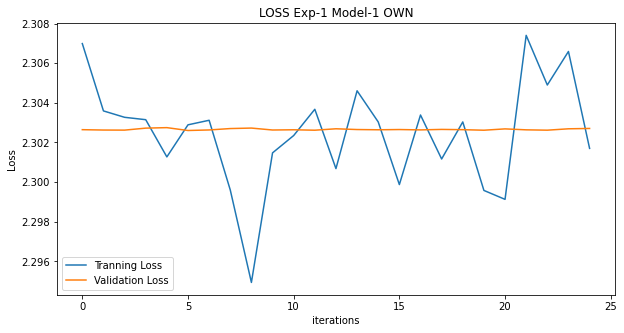

In [95]:
plt.figure(figsize=(10,5))
plt.title("LOSS Exp-1 Model-1 OWN")
plt.plot(_tranning_loss,label="Tranning Loss")
plt.plot(_validation_loss,label="Validation Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

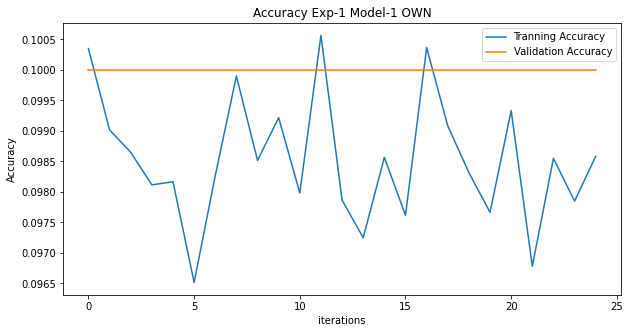

In [96]:
plt.figure(figsize=(10,5))
plt.title("Accuracy Exp-1 Model-1 OWN")
plt.plot(_tranning_acc,label="Tranning Accuracy")
plt.plot(_validation_acc,label="Validation Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Load test dataset

In [97]:

IMAGE_SIZE = model['image_size'] ## set image height width to 128x128
transform = transforms.Compose([
                                # transforms.ToPILImage(),

                                ## this is only for when model is 1
                                transforms.Grayscale(), 
                                
                                # transforms.RandomRotation(20,expand=True), ## adding random rotation 20deg
                                # torchvision.transforms.ColorJitter(hue=.05, saturation=.05), ## adding color filter
                                # transforms.RandomVerticalFlip(), ## adding vertical flip
                                # transforms.RandomHorizontalFlip(), ## adding horizontal flip
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
trainDataset = torchvision.datasets.FashionMNIST(root='./data', 
                            train=True, 
                            transform=transform,  # Normalize the image to [0-1] from [0-255]
                            download=True)

validDataSet = torchvision.datasets.FashionMNIST(root='./data', 
                           train=False, 
                           transform=transform)

'''
MAKING DATASET ITERABLE
'''

trainloader = torch.utils.data.DataLoader(dataset=trainDataset, 
                                           batch_size=1, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

testloader = torch.utils.data.DataLoader(dataset=validDataSet, 
                                          batch_size=1, 
                                          shuffle=False)  

print("Length of the trainloader:", len(trainloader ) * 1)
print("Length of the validationloader:", len(testloader ) * 1)

Length of the trainloader: 60000
Length of the validationloader: 10000


In [98]:
# # BATCH_SIZE = 32 ## number of image batch size 
# base_dir = '/content/PROCESSED_DATASET_170104019' 
# TEST_SIZE = 0.2
# IMAGE_SIZE = model['image_size'] ## set image height width to 128x128
# transform = transforms.Compose([
#                                 # transforms.ToPILImage(),

#                                 ## this is only for when model is 1
#                                 transforms.Grayscale(), 
                                
#                                 # transforms.RandomRotation(20,expand=True), ## adding random rotation 20deg
#                                 # torchvision.transforms.ColorJitter(hue=.05, saturation=.05), ## adding color filter
#                                 # transforms.RandomVerticalFlip(), ## adding vertical flip
#                                 # transforms.RandomHorizontalFlip(), ## adding horizontal flip
#                                 transforms.Resize(IMAGE_SIZE),  ## image resize
#                                 transforms.CenterCrop(IMAGE_SIZE), ## image center crop
#                                 transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
#                                 # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                ])

# #load training dataset 
# dataset = torchvision.datasets.ImageFolder(base_dir, transform=transform)
# n = len(dataset) 
# n_test = int(TEST_SIZE * n) # 10% validation
# trainDataset, validDataSet = torch.utils.data.random_split(dataset,[n - n_test,n_test]) #random split dataset
# trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=1, shuffle=True, pin_memory=True,) 
# testloader = torch.utils.data.DataLoader(validDataSet, batch_size=1, shuffle=True, pin_memory=True,) 
# print("Length of the trainloader:", len(trainloader ) * 1)
# print("Length of the validationloader:", len(testloader ) * 1)

In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load model with state

In [100]:
preTrainedModel = model['model_full']
preTrainedModel.load_state_dict( model['model_state'])

<All keys matched successfully>

## Model prediction  

In [101]:
y_true_tensor = torch.tensor([])
y_pred_tensor = torch.tensor([])
preTrainedModel.eval()
for i,(inputs, labels) in enumerate(testloader):

  inputs, labels = inputs.to(device), labels.to(device)
  outputs = preTrainedModel(inputs)
  _, preds = torch.max(outputs, 1)
  y_true_tensor = torch.cat((y_true_tensor,labels))
  y_pred_tensor = torch.cat((y_pred_tensor,preds))
  print(i)
  # break


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

In [102]:
# Convert tensor to list
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()

## Confusion matrix

In [103]:
matrice = confusion_matrix(y_true,y_pred)
matrice

array([[   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1000,    0,    0,    0,    0,    0,    0,    0]])

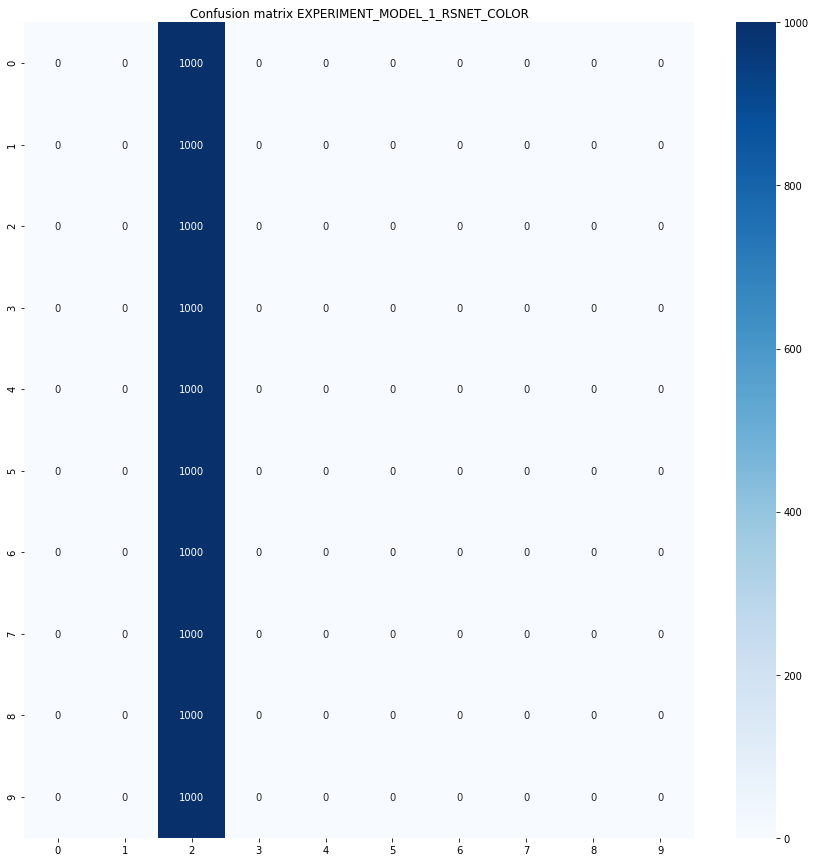

In [104]:

## FOR F-MNIST
# target_names = list(validDataSet.class_to_idx.keys())
# df_cm = pd.DataFrame(matrice,columns=target_names,index=target_names)
# plt.figure(figsize=(15,15))
# sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='g',cmap='Blues',)
# plt.title(f"Confusion matrix {model['MODEL_USED']}")
# plt.show()


## FOR OWN
target_names = list(dataset.class_to_idx.keys())
df_cm = pd.DataFrame(matrice,columns=target_names,index=target_names)
plt.figure(figsize=(15,15))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='g',cmap='Blues',)
plt.title(f"Confusion matrix {model['MODEL_USED']}")
plt.show()

## Classification Report `recision,  recall,  f1-score`

In [105]:
## FOR FNIMST
# target_names = list(validDataSet.class_to_idx.keys())
# classify_report = classification_report(y_true, y_pred, target_names=target_names)
# print(classify_report)


## FOR OWN
target_names = list(dataset.class_to_idx.keys())
classify_report = classification_report(y_true, y_pred, target_names=target_names)
print(classify_report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.10      1.00      0.18      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

